In [2]:
import numpy as np
import random
# import skorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm
import pandas as pd
from ptsa.data.timeseries import TimeSeries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import LeaveOneGroupOut, cross_validate

#### PYTORCH CONFIGURATION SETTINGS ######
device = "cpu"
#FOR GPU: device = "mps" if torch.has_mps else "cpu"
print(f"Using {device} device")

Using cpu device


### Logistic Regression PyTorch implementation

In [3]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
class LogisticRegressionTorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.logistic = torch.nn.Sequential(
            torch.nn.Linear(input_dim, output_dim, bias=True),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        # logits = torch.sigmoid(self.linear(x))
        probs = self.logistic(x)
        return probs
    
class PrecondLogisticRegressionTorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.condition = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=4, padding=1, groups=input_dim),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=3, padding=1, groups=input_dim),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=3, padding=1, groups=input_dim),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=3, padding=1, groups=input_dim),
            nn.AvgPool1d(kernel_size=2),
#             nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=3, padding=1, groups=input_dim),
#             nn.MaxPool1d(kernel_size=2),
        )
        self.logistic = nn.Sequential(
            nn.Linear(input_dim, output_dim, bias=True),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_cond = self.condition(x)
        probs = self.logistic(x)
        return probs

    
def train_loop(dataloader, model, loss_fn, optimizer, print_nth_batch=4, l2=None):
    size = len(dataloader.dataset)
    print("yay training")
    for batch, (X, y) in enumerate(dataloader):
        # print(y)
        # Compute prediction and loss
        pred = torch.squeeze(model(X))
        # print(pred)
        # regularization, computing largest singular value
        loss = loss_fn(pred, y)
        # if l2:
        #     loss = loss + l2*l2_reg(model)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % print_nth_batch == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # we don't want to track gradients here because we're just doing
    # a forward pass to evaluate predictions
    with torch.no_grad():
        for X, y in dataloader:
            pred = torch.squeeze(model(X))
            test_loss += loss_fn(pred, y).item()
            # round predicted probs to get label prediction, compute n correct
            correct += (pred.round() == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def test_auc_score(dataset, model):
    with torch.no_grad():
        X, y = dataset[:]
        pred = model(X)
        pred, y = pred.detach().numpy(), y.detach().numpy()
        score = roc_auc_score(y_true=y, y_score=pred)
        print("AUC:", score)
    return score

def l2_reg(model):
  """
  This function calculates the l2 norm of the all the tensors in the model
  Args:
    model: nn.module
      Neural network instance
  Returns:
    l2: float
      L2 norm of the all the tensors in the model
  """

  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)

  return l2

In [8]:
X_1 = torch.rand(1000, 128) #+ .2
y_1 = torch.zeros(1000,)
X_2 = torch.rand(1000, 128) #- .1
y_2 = torch.ones(1000,)

X = torch.cat((X_1, X_2))
y = torch.cat((y_1, y_2))

dataset = SimpleDataset(X, y)

train_prop = .8
train_num = int(train_prop * len(dataset))
test_num = len(X) - train_num


train_set, test_set = torch.utils.data.random_split(dataset,
                                                    [train_num, test_num])


target = train_set.dataset.y[train_set.indices]
cls_weights = torch.from_numpy(
    compute_class_weight(class_weight='balanced',
                         classes=np.unique(target.numpy()),
                         y=target.numpy())
)
weights = cls_weights[target.numpy()]
sampler = WeightedRandomSampler(weights, len(target.numpy()), replacement=True)

train_dataloader = DataLoader(train_set, batch_size=100, sampler=sampler)
test_dataloader = DataLoader(test_set, batch_size=100, shuffle=True)

In [9]:
model = LogisticRegressionTorch(128)

loss_fn = torch.nn.BCELoss()
weight_decay = 1
lr = 5e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

In [10]:
%%time
set_seed(56)
epochs = 10
for t in range(epochs):
    print(f"{'-'*30}\nEpoch {t+1}\n{'-'*30}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(train_dataloader, model, loss_fn)
print("Done!")

Random seed 56 has been set.
------------------------------
Epoch 1
------------------------------
yay training
loss: 0.700848  [    0/ 1600]
loss: 3.608657  [  400/ 1600]
loss: 2.541048  [  800/ 1600]
loss: 3.054665  [ 1200/ 1600]
Test Error: 
 Accuracy: 49.3%, Avg loss: 2.443158 

------------------------------
Epoch 2
------------------------------
yay training
loss: 2.431442  [    0/ 1600]
loss: 2.771903  [  400/ 1600]
loss: 3.974485  [  800/ 1600]
loss: 3.103239  [ 1200/ 1600]
Test Error: 
 Accuracy: 49.2%, Avg loss: 2.955838 

------------------------------
Epoch 3
------------------------------
yay training
loss: 2.563055  [    0/ 1600]
loss: 2.165828  [  400/ 1600]
loss: 2.362202  [  800/ 1600]
loss: 4.232868  [ 1200/ 1600]
Test Error: 
 Accuracy: 49.2%, Avg loss: 2.562103 

------------------------------
Epoch 4
------------------------------
yay training
loss: 2.818193  [    0/ 1600]
loss: 2.694793  [  400/ 1600]
loss: 2.470912  [  800/ 1600]
loss: 3.691533  [ 1200/ 1600]
Tes

In [11]:
[p for p in model.parameters()]

[Parameter containing:
 tensor([[0.0873, 0.0627, 0.0893, 0.0677, 0.0944, 0.1175, 0.1002, 0.0882, 0.0907,
          0.0787, 0.0842, 0.0790, 0.0744, 0.0822, 0.0884, 0.0700, 0.0678, 0.0974,
          0.0767, 0.0932, 0.0832, 0.0784, 0.0782, 0.0734, 0.0815, 0.0730, 0.0838,
          0.0893, 0.0743, 0.0683, 0.0827, 0.0797, 0.1005, 0.0763, 0.0731, 0.0935,
          0.0985, 0.0928, 0.0562, 0.0774, 0.0985, 0.0951, 0.0668, 0.0929, 0.0797,
          0.0988, 0.0913, 0.0982, 0.1249, 0.0841, 0.0811, 0.0687, 0.0641, 0.0764,
          0.0814, 0.0916, 0.0688, 0.0698, 0.0840, 0.0582, 0.1002, 0.0767, 0.0970,
          0.0733, 0.0931, 0.1025, 0.0664, 0.0462, 0.0751, 0.0708, 0.0863, 0.0707,
          0.0872, 0.0753, 0.0955, 0.0802, 0.0595, 0.0785, 0.0980, 0.0666, 0.0853,
          0.0780, 0.0771, 0.0829, 0.1118, 0.0974, 0.0849, 0.0660, 0.0730, 0.0833,
          0.0701, 0.0702, 0.0955, 0.0938, 0.0811, 0.0885, 0.0848, 0.0828, 0.0817,
          0.0879, 0.0655, 0.0761, 0.0785, 0.0909, 0.1033, 0.0626, 0.0782, 0

## Compare to sklearn

In [12]:
%%time
sk_model = LogisticRegression(penalty='l2', C=1e-4, class_weight='balanced', fit_intercept=True, solver='saga')

train_idx = train_set.indices
test_idx = test_set.indices
sk_train_X = train_set.dataset.X[train_idx].detach().numpy()
sk_train_y = train_set.dataset.y[train_idx].detach().numpy()
sk_test_X = test_set.dataset.X[test_idx].detach().numpy()
sk_test_y = test_set.dataset.y[test_idx].detach().numpy()
fit = sk_model.fit(sk_train_X, sk_train_y)

sk_pred = fit.predict(sk_test_X)

CPU times: user 517 ms, sys: 140 ms, total: 658 ms
Wall time: 167 ms


In [13]:
accuracy_score(sk_test_y, sk_pred)

0.5125

In [14]:
sk_model.coef_

array([[ 2.4131160e-04, -4.6132575e-04,  3.4445897e-04,  1.8519568e-04,
        -5.4830051e-04,  1.1141150e-03, -6.4614945e-04, -1.1913801e-03,
        -3.7327985e-04, -3.0545960e-04, -2.6876479e-04, -3.1180453e-04,
         4.6721124e-04,  3.5252771e-04,  8.6313921e-05,  7.5289333e-04,
        -7.7934272e-04,  9.0795686e-04, -2.3124235e-04,  2.1582688e-04,
        -9.3807808e-05, -1.0474667e-04,  4.9194007e-04,  5.1707128e-04,
        -1.9614457e-04,  7.8363984e-04, -2.8293953e-05,  7.8600424e-05,
        -2.0287099e-04, -2.3677357e-04, -3.1233093e-04, -1.0019947e-03,
        -4.0162457e-05,  5.6729501e-04,  3.0720248e-04, -4.3040048e-04,
        -2.2268898e-04,  2.5102257e-04, -2.8418738e-04,  6.3262979e-04,
        -2.7471068e-04,  2.0574310e-04,  3.1120345e-04,  1.2792593e-03,
         5.6858611e-04,  2.4843967e-04,  5.3513999e-04,  9.0322195e-04,
        -4.8988668e-04, -1.2738239e-03,  6.8290345e-04,  5.9528858e-04,
        -4.0988976e-04,  8.5013092e-04,  3.0823151e-04,  2.08740

In [15]:
sk_model.intercept_

array([-0.00210631], dtype=float32)

## Using lab data

In [4]:
ts = TimeSeries.from_hdf(
    "/scratch/jrudoler/scalp_features/LTP093_feats.h5",
)

In [20]:
ts.unstack("features")

<xarray.TimeSeries 'data' (event: 13248, frequency: 20, channel: 124)>
array([[[ 1.39587653e+00,  1.70742426e+00,  5.54105948e-01, ...,
          9.26949346e-01,  3.60765826e-01, -4.20605905e-01],
        [ 4.44943446e-01,  1.57553103e+00, -1.62710896e-01, ...,
         -4.91543365e-01, -2.50837113e-01, -7.30371355e-01],
        [-1.86757167e-01,  2.04167053e-02, -4.20472639e-01, ...,
         -6.45690370e-01, -1.85106045e-01, -3.39612897e-01],
        ...,
        [-8.95425926e-01,  9.27001518e-01, -2.30120292e-01, ...,
          5.17276271e-01, -9.61746937e-01, -2.34628751e-01],
        [-8.27941491e-01,  7.75734020e-01, -2.41032913e-01, ...,
         -4.35922181e-01, -1.03758902e+00, -5.21911629e-01],
        [-9.90258257e-01,  8.86551266e-01, -5.43131051e-01, ...,
         -9.71533419e-01, -1.26069151e+00, -6.74849604e-01]],

       [[ 1.27620053e+00,  1.02151463e+00, -1.81685460e+00, ...,
         -1.56056774e+00, -1.29049560e+00, -1.10462495e+00],
        [ 1.91133981e+00, -2.95863846e-01, -7.25485833e-01, ...,
         -2.64510390e+00, -1.35901883e+00, -1.63381166e+00],
        [ 9.65586904e-01, -9.59395733e-01, -3.25459627e-01, ...,
         -2.12805101e+00, -1.76594402e+00, -3.90817817e-01],
...
        [ 1.67538293e-01, -2.06169238e-01,  7.16212495e-01, ...,
         -3.87131904e-01, -9.77682499e-02,  4.38739303e-01],
        [ 2.48287200e-01, -8.55439342e-02,  7.79705614e-01, ...,
         -3.52362688e-01,  1.05727347e-01,  4.35295684e-01],
        [ 1.99468895e-01, -8.62287564e-02,  9.38160889e-01, ...,
         -3.55865449e-01,  3.45736801e-01,  4.89451156e-01]],

       [[-2.50150520e-01, -6.87843058e-02, -7.37521323e-02, ...,
         -1.57742590e+00, -3.11012437e+00, -2.08849377e-01],
        [-5.59610990e-01,  1.31475643e+00,  1.13463066e+00, ...,
          4.75671981e-01, -4.30557120e-01,  5.81532752e-01],
        [ 7.17756255e-01,  1.44361107e+00,  3.51273401e-01, ...,
          1.03740257e+00, -2.88860295e-02, -7.96719201e-01],
        ...,
        [-1.19300851e-01,  6.08363101e-01,  9.03034158e-01, ...,
         -2.84023610e-01, -6.70062590e-02,  7.20343371e-01],
        [-5.60094173e-02,  2.65321397e-01,  6.43879182e-01, ...,
         -3.29366288e-01,  4.47337017e-02,  2.73048754e-01],
        [-2.03685595e-01,  2.30178227e-01,  8.03178039e-01, ...,
         -6.23034482e-01,  7.64283630e-02,  2.58570232e-01]]])
Coordinates: (12/28)
  * frequency           (frequency) float64 2.0 2.534 3.212 ... 142.0 180.0
  * channel             (channel) object 'E1' 'E10' 'E100' ... 'E97' 'E98' 'E99'
    samplerate          float64 500.0
  * event               (event) object MultiIndex
  * begin_distractor    (event) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * begin_math_correct  (event) int64 -999 -999 -999 -999 ... -999 -999 -999
    ...                  ...
  * rectime             (event) int64 -999 -999 -999 -999 ... -999 -999 -999
  * serialpos           (event) int64 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24
  * session             (event) int64 0 0 0 0 0 0 0 0 ... 23 23 23 23 23 23 23
  * subject             (event) object 'LTP093' 'LTP093' ... 'LTP093' 'LTP093'
  * trial               (event) int64 1 1 1 1 1 1 1 1 ... 24 24 24 24 24 24 24
  * type                (event) object 'WORD' 'WORD' 'WORD' ... 'WORD' 'WORD'
Attributes:
    rel_start:    200
    rel_stop:     1600
    buffer_time:  1000
    freqs:        [  2.           2.53445663   3.21173521   4.07000181   5.15...
    width:        4
    experiment:   ltpFR2
    clean:        1
    save:         1
    reference:    average
    cap_type:     EGI

In [5]:
X_npy = ts.data
y_npy = ts.recalled.data
X = torch.tensor(ts.data).float()
y = torch.tensor(ts.recalled.data).float()
dataset = SimpleDataset(X, y)
sessions = ts.session.values

In [ ]:
set_seed(56)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
torch_auc_list = []
sk_auc_list = []
logo = LeaveOneGroupOut()
for (i, (train_idx, test_idx)) in tqdm(list(enumerate(logo.split(X, y, groups=sessions)))):
    print(f"{'#'*30}\nSESSION {i}\n{'#'*30}")
    ## create model ##
    model = LogisticRegressionTorch(X.shape[-1])
    loss_fn = torch.nn.BCELoss()
    alpha = 1
    lr = 5e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=10)
    ## data ##
    train_set = SimpleDataset(X[train_idx], y[train_idx])
    test_set = SimpleDataset(X[test_idx], y[test_idx])
    ## class balancing ##
    cls_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_set.y.detach().numpy()),
        y=train_set.y.detach().numpy(),
    )
    weights = cls_weights[train_set.y.detach().numpy().astype(int)]
    sampler = WeightedRandomSampler(
        weights, len(train_set.y.detach().numpy()), replacement=True
    )

    train_dataloader = DataLoader(train_set, batch_size=200, sampler=sampler)

    ## training epochs ##
    EPOCHS = 10
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[2, 4, 6, 8])
    for t in range(EPOCHS):
        print(f"{'-'*30}\nEpoch {t+1}\n{'-'*30}")
        train_loop(train_dataloader, model, loss_fn, optimizer, print_nth_batch=8)
        out = test_auc_score(test_set, model)
        if t in scheduler.milestones:
            scheduler.step()
    torch_auc_list.append(out)

    ## STANDARD SKLEARN LOGISTIC REGRESSION ###
    lr_sk = LogisticRegression(
        # penalty="none", class_weight="balanced", fit_intercept=True, max_iter=1000
        C=1e-4, class_weight="balanced", fit_intercept=True, max_iter=1000, solver='saga'
    )
    lr_sk.fit(X=X_npy[train_idx], y=y_npy[train_idx])
    pred = lr_sk.predict_proba(X_npy[test_idx])[:, 1]
    score = roc_auc_score(y_true=y_npy[test_idx], y_score=pred)
    sk_auc_list.append(score)
    print("sklearn AUC:", score)


Random seed 56 has been set.


  0%|          | 0/23 [00:00<?, ?it/s]

##############################
SESSION 0
##############################
------------------------------
Epoch 1
------------------------------
yay training
loss: 0.745432  [    0/12672]
loss: 1.996793  [ 1600/12672]
loss: 2.304743  [ 3200/12672]
loss: 2.183406  [ 4800/12672]
loss: 1.957629  [ 6400/12672]
loss: 1.758837  [ 8000/12672]
loss: 1.953741  [ 9600/12672]
loss: 2.101884  [11200/12672]
AUC: 0.5432395074139231
------------------------------
Epoch 2
------------------------------
yay training
loss: 2.437188  [    0/12672]
loss: 2.152052  [ 1600/12672]
loss: 1.826231  [ 3200/12672]
loss: 2.456435  [ 4800/12672]
loss: 1.164517  [ 6400/12672]
loss: 2.500187  [ 8000/12672]
loss: 2.419441  [ 9600/12672]
loss: 1.984975  [11200/12672]
AUC: 0.541090726313144
------------------------------
Epoch 3
------------------------------
yay training
loss: 2.699327  [    0/12672]
loss: 2.364421  [ 1600/12672]
loss: 2.032473  [ 3200/12672]
loss: 2.365137  [ 4800/12672]
loss: 2.494399  [ 6400/12672]
lo

In [ ]:
# df = pd.DataFrame(data={"sklearn":sk_auc_list, "pytorch":torch_auc_list})
df = pd.DataFrame(data={"pytorch":torch_auc_list})
df

In [110]:
df.to_csv("LTP093_loso_sgd_l2_unit.csv")

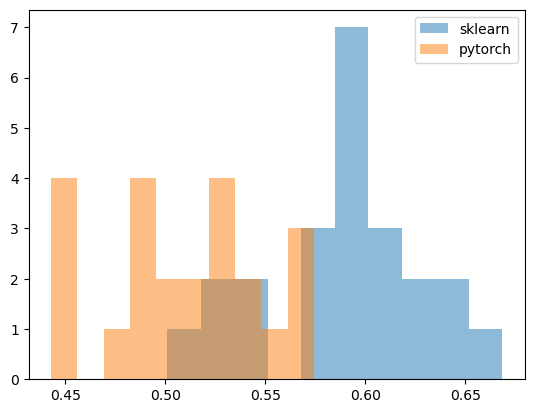

In [19]:
plt.hist(df['sklearn'], bins=10, label='sklearn', alpha=.5)
plt.hist(df['pytorch'], bins=10, label='pytorch', alpha=.5)
plt.legend()